In [1]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py
import bz2
import multiprocessing as mp


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors, KDTree

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

# Extracting the point collection and the descriptors

In [2]:
with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)
    
with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
    descriptors = pickle.load(f)
    
with open('descriptors/new_complete_RANSAC_res5_4by5_descriptors.pickle','rb') as f:
    ransac_descriptors = pickle.load(f)
    
results_path = 'testing_results'

if not os.path.exists(results_path): os.mkdir(results_path)

In [5]:
# We'll use only a 300 samples for this.
with open('sample_points.pickle','rb') as f:
    sample_points = pickle.load(f)
    
sample_points_300 = np.random.choice(1000,300,False)

len(sample_points), len(sample_points_300)

(1000, 300)

In [18]:

overall_processing_properties = []

for radius in np.arange(0.5,4.1,0.5):

    t0 = time.time()
    t1 = time.time()

    per_radius_properties = []

    print("radius =",radius)
    
    for s_i in sample_points_300:

        t2 = time.time()

        obj_, object_name, original_vertex = sample_points[s_i]

        pointCloud = []

        try:
            trial = np.random.randint(5)

            with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
                ransac_trial_point_collection = pickle.load(f)

            object_, pointCloud_, tri_ = ransac_trial_point_collection[int(obj_)]

            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])

            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get ransac samples for",trial,obj_,dist_.shape,ind_.shape)
            continue

        t3 = time.time() # extraction

        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        # ROTATION
        random_theta =  (2*np.pi)*np.random.random()# from [0, 2pi)
        random_axis = np.random.choice(np.arange(0,3))
        rotated_pointCloud = rotatePointCloud(pointCloud, random_theta, random_axis)

        # TRANSLATION
        pointCloud = np.asarray(rotated_pointCloud)
        random_tx_axis = np.random.choice(np.arange(0,3))
        random_translation = np.random.random()
        pointCloud[:,random_tx_axis] = pointCloud[:,random_tx_axis] + random_translation

        try:
            p_descriptors, p_keypoints, p_d_c, kp_time, desc_time = getSpinImageDescriptorsTEST(
                pointCloud,
                down_resolution = 5,
                cylindrical_quantization = [4,5]
            )
        except Exception as ex:
            print("Error getting descriptors of",obj_meta[1],len(t_pointCloud))
            print("Error Message:",ex)
            continue
            
        t4 = time.time() # description
        
        # Resetting the diff_Ratio matrix
        diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
        diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
        diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

        #print(diff_ratios.shape)
        local_keypoint_matches = []

        for i_r, ref_descriptor in enumerate(descriptors):

            r_descriptors = ref_descriptor[1]
            r_keypoints = ref_descriptor[2]

            matching_range = np.arange(r_descriptors.shape[1])

            try:    
                tree = KDTree(r_descriptors, leaf_size = 2)
                diff, f_nearestneighbor = tree.query(p_descriptors,k=2)
                #print(p_descriptors.shape,r_descriptors.shape)
                #print(diff.shape, f_nearestneighbor.shape)
                diff = diff/np.amax(diff) # max-normalization of differences
                diff_ratio = diff[:,0]/diff[:,1]
                diff_ratios[:,i_r] = diff_ratio
                diff_scores[:,i_r] = diff
                diff_indexs[:,i_r] = f_nearestneighbor

                # Taking note of the matched keypoints
                local_keypoint_matches.append([
                    [obj_, object_name, original_vertex],
                    p_keypoints,
                    r_keypoints[f_nearestneighbor[:,0]]
                ])

            except Exception as ex:
                print("Error Matching:",ex)

        t5 = time.time() # inference
        
        if len(local_keypoint_matches) == 0: 
            print("skipped",object_name)
            continue

        #t5 = time.time()
        
        per_radius_properties.append([
            diff_ratios.shape,
            diff_indexs.shape,
            diff_scores.shape,
            t3 - t2, # extraction
            t4 - t3, # description
            t5 - t4  # matching or inference
        ])
        
        if len(per_radius_properties) % 66 == 2:
            print(radius, "  ",
                diff_ratios.shape,
                " extraction: {:.3f} s, description: {:.3f} s (sel: {:.3f} , des: {:.3f} s), inference: {:.3f} s".format(
                    t3 - t2, # extraction
                    t4 - t3, # description
                    kp_time, desc_time,
                    t5 - t4  # matching or inference
                )
            )
        
    overall_processing_properties.append([
        radius,
        per_radius_properties
    ])
    
    with open('testing_results/partial_exp/ransac_evaluation_properties_extended.pickle','wb') as f:
        pickle.dump(overall_processing_properties,f)
    
    

radius = 0.5
0.5    (40, 7)  extraction: 0.038 s, description: 0.491 s (sel: 0.001 , des: 0.491 s), inference: 0.250 s
0.5    (47, 7)  extraction: 0.046 s, description: 0.542 s (sel: 0.001 , des: 0.542 s), inference: 0.249 s
0.5    (60, 7)  extraction: 0.036 s, description: 1.024 s (sel: 0.001 , des: 1.022 s), inference: 0.268 s
0.5    (36, 7)  extraction: 0.036 s, description: 0.290 s (sel: 0.000 , des: 0.290 s), inference: 0.229 s
0.5    (28, 7)  extraction: 0.038 s, description: 0.071 s (sel: 0.000 , des: 0.070 s), inference: 0.225 s
radius = 1.0
1.0    (164, 7)  extraction: 0.036 s, description: 2.912 s (sel: 0.001 , des: 2.910 s), inference: 0.398 s
1.0    (127, 7)  extraction: 0.033 s, description: 1.716 s (sel: 0.001 , des: 1.714 s), inference: 0.333 s
1.0    (100, 7)  extraction: 0.037 s, description: 0.972 s (sel: 0.001 , des: 0.971 s), inference: 0.307 s
1.0    (113, 7)  extraction: 0.052 s, description: 1.650 s (sel: 0.001 , des: 1.649 s), inference: 0.288 s
1.0    (100, 7) 

In [6]:

overall_processing_properties = []

for radius in np.arange(0.5,4.1,0.5):

    t0 = time.time()
    t1 = time.time()

    per_radius_properties = []

    print("radius =",radius)
    
    for s_i in sample_points_300:

        t2 = time.time()

        obj_, object_name, original_vertex = sample_points[s_i]

        pointCloud = []

        try:
            trial = np.random.randint(5)

            with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
                ransac_trial_point_collection = pickle.load(f)

            object_, pointCloud_, tri_ = ransac_trial_point_collection[int(obj_)]

            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])

            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get ransac samples for",trial,obj_,dist_.shape,ind_.shape)
            continue

        t3 = time.time() # extraction

        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        # ROTATION
        random_theta =  (2*np.pi)*np.random.random()# from [0, 2pi)
        random_axis = np.random.choice(np.arange(0,3))
        rotated_pointCloud = rotatePointCloud(pointCloud, random_theta, random_axis)

        # TRANSLATION
        pointCloud = np.asarray(rotated_pointCloud)
        random_tx_axis = np.random.choice(np.arange(0,3))
        random_translation = np.random.random()
        pointCloud[:,random_tx_axis] = pointCloud[:,random_tx_axis] + random_translation

        try:
            p_descriptors, p_keypoints, p_d_c, kp_time, desc_time = getSpinImageDescriptorsTest1(
                pointCloud,
                down_resolution = 5,
                cylindrical_quantization = [4,5]
            )
        except Exception as ex:
            print("Error getting descriptors of",obj_meta[1],len(t_pointCloud))
            print("Error Message:",ex)
            continue
            
        t4 = time.time() # description
        
        # Resetting the diff_Ratio matrix
        diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
        diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
        diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

        #print(diff_ratios.shape)
        local_keypoint_matches = []

        for i_r, ref_descriptor in enumerate(descriptors):

            r_descriptors = ref_descriptor[1]
            r_keypoints = ref_descriptor[2]

            matching_range = np.arange(r_descriptors.shape[1])

            try:    
                tree = KDTree(r_descriptors, leaf_size = 2)
                diff, f_nearestneighbor = tree.query(p_descriptors,k=2)
                #print(p_descriptors.shape,r_descriptors.shape)
                #print(diff.shape, f_nearestneighbor.shape)
                diff = diff/np.amax(diff) # max-normalization of differences
                diff_ratio = diff[:,0]/diff[:,1]
                diff_ratios[:,i_r] = diff_ratio
                diff_scores[:,i_r] = diff
                diff_indexs[:,i_r] = f_nearestneighbor

                # Taking note of the matched keypoints
                local_keypoint_matches.append([
                    [obj_, object_name, original_vertex],
                    p_keypoints,
                    r_keypoints[f_nearestneighbor[:,0]]
                ])

            except Exception as ex:
                print("Error Matching:",ex)

        t5 = time.time() # inference
        
        if len(local_keypoint_matches) == 0: 
            print("skipped",object_name)
            continue

        #t5 = time.time()
        
        per_radius_properties.append([
            diff_ratios.shape,
            diff_indexs.shape,
            diff_scores.shape,
            t3 - t2, # extraction
            t4 - t3, # description
            t5 - t4  # matching or inference
        ])
        
        if len(per_radius_properties) % 66 == 2:
            print(radius, "  ",
                diff_ratios.shape,
                " extraction: {:.3f} s, description: {:.3f} s (sel: {:.3f} , des: {:.3f} s), inference: {:.3f} s".format(
                    t3 - t2, # extraction
                    t4 - t3, # description
                    kp_time, desc_time,
                    t5 - t4  # matching or inference
                )
            )
        
    overall_processing_properties.append([
        radius,
        per_radius_properties
    ])
    
    with open('testing_results/partial_exp/ransac_evaluation_properties_extended_try_test1.pickle','wb') as f:
        pickle.dump(overall_processing_properties,f)
    
    

radius = 0.5
0.5    (19, 7)  extraction: 0.040 s, description: 0.014 s (sel: 0.001 , des: 0.012 s), inference: 0.263 s
0.5    (39, 7)  extraction: 0.038 s, description: 0.034 s (sel: 0.001 , des: 0.033 s), inference: 0.314 s
0.5    (46, 7)  extraction: 0.068 s, description: 0.050 s (sel: 0.001 , des: 0.049 s), inference: 0.276 s
0.5    (43, 7)  extraction: 0.064 s, description: 0.046 s (sel: 0.001 , des: 0.045 s), inference: 0.260 s
0.5    (61, 7)  extraction: 0.038 s, description: 0.067 s (sel: 0.001 , des: 0.066 s), inference: 0.273 s
radius = 1.0
1.0    (162, 7)  extraction: 0.026 s, description: 0.184 s (sel: 0.001 , des: 0.183 s), inference: 0.376 s
1.0    (147, 7)  extraction: 0.043 s, description: 0.198 s (sel: 0.001 , des: 0.196 s), inference: 0.465 s
1.0    (164, 7)  extraction: 0.043 s, description: 0.313 s (sel: 0.002 , des: 0.311 s), inference: 0.430 s
1.0    (130, 7)  extraction: 0.039 s, description: 0.142 s (sel: 0.001 , des: 0.141 s), inference: 0.328 s
1.0    (120, 7) 

KeyboardInterrupt: 

In [ ]:

overall_processing_properties = []

for radius in np.arange(0.5,4.1,0.5):

    t0 = time.time()
    t1 = time.time()

    per_radius_properties = []

    print("radius =",radius)
    
    for s_i in sample_points_300:

        t2 = time.time()

        obj_, object_name, original_vertex = sample_points[s_i]

        pointCloud = []

        try:
            trial = np.random.randint(5)

            with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
                ransac_trial_point_collection = pickle.load(f)

            object_, pointCloud_, tri_ = ransac_trial_point_collection[int(obj_)]

            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])

            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get ransac samples for",trial,obj_,dist_.shape,ind_.shape)
            continue

        t3 = time.time() # extraction

        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        # ROTATION
        random_theta =  (2*np.pi)*np.random.random()# from [0, 2pi)
        random_axis = np.random.choice(np.arange(0,3))
        rotated_pointCloud = rotatePointCloud(pointCloud, random_theta, random_axis)

        # TRANSLATION
        pointCloud = np.asarray(rotated_pointCloud)
        random_tx_axis = np.random.choice(np.arange(0,3))
        random_translation = np.random.random()
        pointCloud[:,random_tx_axis] = pointCloud[:,random_tx_axis] + random_translation

        try:
            p_descriptors, p_keypoints, p_d_c, kp_time, desc_time = getSpinImageDescriptorsTest1(
                pointCloud,
                down_resolution = 5,
                cylindrical_quantization = [4,5],
                old = True
            )
        except Exception as ex:
            print("Error getting descriptors of",obj_meta[1],len(t_pointCloud))
            print("Error Message:",ex)
            continue
            
        t4 = time.time() # description
        
        # Resetting the diff_Ratio matrix
        diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
        diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
        diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

        #print(diff_ratios.shape)
        local_keypoint_matches = []

        for i_r, ref_descriptor in enumerate(descriptors):

            r_descriptors = ref_descriptor[1]
            r_keypoints = ref_descriptor[2]

            matching_range = np.arange(r_descriptors.shape[1])

            try:    
                tree = KDTree(r_descriptors, leaf_size = 2)
                diff, f_nearestneighbor = tree.query(p_descriptors,k=2)
                #print(p_descriptors.shape,r_descriptors.shape)
                #print(diff.shape, f_nearestneighbor.shape)
                diff = diff/np.amax(diff) # max-normalization of differences
                diff_ratio = diff[:,0]/diff[:,1]
                diff_ratios[:,i_r] = diff_ratio
                diff_scores[:,i_r] = diff
                diff_indexs[:,i_r] = f_nearestneighbor

                # Taking note of the matched keypoints
                local_keypoint_matches.append([
                    [obj_, object_name, original_vertex],
                    p_keypoints,
                    r_keypoints[f_nearestneighbor[:,0]]
                ])

            except Exception as ex:
                print("Error Matching:",ex)

        t5 = time.time() # inference
        
        if len(local_keypoint_matches) == 0: 
            print("skipped",object_name)
            continue

        #t5 = time.time()
        
        per_radius_properties.append([
            diff_ratios.shape,
            diff_indexs.shape,
            diff_scores.shape,
            t3 - t2, # extraction
            t4 - t3, # description
            t5 - t4  # matching or inference
        ])
        
        if len(per_radius_properties) % 66 == 2:
            print(radius, "  ",
                diff_ratios.shape,
                " extraction: {:.3f} s, description: {:.3f} s (sel: {:.3f} , des: {:.3f} s), inference: {:.3f} s".format(
                    t3 - t2, # extraction
                    t4 - t3, # description
                    kp_time, desc_time,
                    t5 - t4  # matching or inference
                )
            )
        
    overall_processing_properties.append([
        radius,
        per_radius_properties
    ])
    
    with open('testing_results/partial_exp/ransac_evaluation_properties_extended_try_test1.pickle','wb') as f:
        pickle.dump(overall_processing_properties,f)
    
    

radius = 0.5
0.5    (20, 7)  extraction: 0.024 s, description: 0.017 s (sel: 0.004 , des: 0.014 s), inference: 0.229 s
0.5    (42, 7)  extraction: 0.034 s, description: 0.042 s (sel: 0.006 , des: 0.035 s), inference: 0.241 s
0.5    (46, 7)  extraction: 0.037 s, description: 0.045 s (sel: 0.006 , des: 0.038 s), inference: 0.255 s
0.5    (37, 7)  extraction: 0.033 s, description: 0.035 s (sel: 0.006 , des: 0.029 s), inference: 0.249 s
0.5    (63, 7)  extraction: 0.034 s, description: 0.082 s (sel: 0.011 , des: 0.070 s), inference: 0.280 s
radius = 1.0
1.0    (154, 7)  extraction: 0.023 s, description: 0.181 s (sel: 0.016 , des: 0.165 s), inference: 0.325 s
1.0    (145, 7)  extraction: 0.035 s, description: 0.210 s (sel: 0.018 , des: 0.192 s), inference: 0.378 s
1.0    (201, 7)  extraction: 0.041 s, description: 0.406 s (sel: 0.032 , des: 0.373 s), inference: 0.460 s
1.0    (115, 7)  extraction: 0.070 s, description: 0.143 s (sel: 0.017 , des: 0.125 s), inference: 0.359 s
1.0    (297, 7) 

In [7]:
# Getting the "spin image" descriptors for a given point cloud    
def getSpinImageDescriptorsTest1(_point_cloud,
                            resolution = 20,
                            normalize = True,
                            down_resolution = 3, #keypoint resolution
                            #localize = False,
                            local_radius = 1.0,
                            cylindrical_quantization = [10,20],
                            verbose = False,
                            old = False,
                            key_cap = 50, 
                            strict_cap = False
                           ):
    
    np_pointCloud = np.asarray(np.copy(_point_cloud))
    other_pc = np.copy(np_pointCloud)
    
    t0 = time.time()
    
    if old:
        chosen_points = getQuantizedPointCloudOnly(np_pointCloud,down_resolution,verbose=verbose)
        if verbose: print("Old:",chosen_points.shape)
    else:
        chosen_points = getQuantizedPointCloudOnlyTEST(np_pointCloud,down_resolution,verbose=verbose)
        if verbose: print("New:",chosen_points.shape)

    chosen_points = np.delete(chosen_points,np.where(LA.norm(chosen_points[:,3:],axis=1)== 0)[0],0)
    
    t1 = time.time()
    
    if strict_cap and len(chosen_points) > key_cap:
        chosen_points = chosen_points[np.random.choice(len(chosen_points),key_cap)]
        if verbose: print("Capped chosen points to", key_cap)
    
    """
    if verbose:
        unique_normals = np.unique(chosen_points[:,3:],axis=0)

        for normal in unique_normals:

            if np.round(np.abs(np.dot(normal,[0,1,0]))) == 0:
                print("  IN Complete",object_name,"Vertical",np.abs(np.dot(normal,[0,1,0])),normal,LA.norm(normal,2))
                print("  IN Chosen Points before:",chosen_points.shape)
                #vertical = True

    """
    
    view_invariant_descriptor_cylinders = np.zeros(
        (np.append(len(chosen_points),
                   np.asarray(cylindrical_quantization)
                   #np.asarray(cylindrical_quantization*0.5*resolution,dtype = np.uint32)
                   #[int(resolution*cylindrical_quantization[0]),int(resolution*cylindrical_quantization[1])]
                  )
        ), dtype=np.float16)
    #    shape is (number of points, number of a bins, number of b bins)
    #print(view_invariant_descriptor_cylinders.shape)
    
    # N  = len(chosen points), M = len(other pc)

    for i,c_p in enumerate(chosen_points):

        k_ps = other_pc[:,:3] - c_p[:3] # point (vertex) differences; M
        k_ps = np.delete(k_ps,np.where(LA.norm(k_ps,axis=1)==0)[0],0) # removing itself; M-1

        #if localize:
        #    k_ps = np.delete(k_ps,np.where(LA.norm(k_ps,axis=1)>local_radius)[0],0)

        # len(theta) = M-1
        theta = np.arccos(np.clip(np.sum(c_p[3:]*k_ps,axis=1)/(LA.norm(c_p[3:])*LA.norm(k_ps,axis=1)),-1,1))# normal at keypoint

        
        d_a = cylindrical_quantization[0]*LA.norm(k_ps,axis=1)*np.sin(theta)
        d_b = np.clip(cylindrical_quantization[1]*0.5*LA.norm(k_ps,axis=1)*np.cos(theta)+cylindrical_quantization[1]*0.5,
                      0,cylindrical_quantization[1]-1)
        
        # removing the points that are outside of the spin region
        k_ps = np.delete(k_ps,np.where(d_a>=cylindrical_quantization[0]-1)[0],0)
        d_b = np.delete(d_b,np.where(d_a>=cylindrical_quantization[0]-1)[0],0)
        d_a = np.delete(d_a,np.where(d_a>=cylindrical_quantization[0]-1)[0],0)

        k_ps = np.delete(k_ps,np.where(d_b>=cylindrical_quantization[1]-1)[0],0)
        d_a = np.delete(d_a,np.where(d_b>=cylindrical_quantization[1]-1)[0],0)
        d_b = np.delete(d_b,np.where(d_b>=cylindrical_quantization[1]-1)[0],0)
        
        a = np.asarray(np.ceil(np.clip(d_a,0,cylindrical_quantization[0]-1)), dtype = np.uint)
        b = np.asarray(np.ceil(np.clip(d_b,0,cylindrical_quantization[1]-1)), dtype = np.uint)

        """for k,_ in enumerate(k_ps):
            
            if LA.norm(k_ps[k]) == 0:
                continue

            # skip points that are beyond the scope of the pre-defined descriptor
            if d_a[k] >= cylindrical_quantization[0]-1 or d_b[k] >= cylindrical_quantization[1]-1:
                continue
            if d_a[k]>a[k] or d_b[k]>b[k]:
                continue
            diff_a = a[k]-d_a[k]
            diff_b = b[k]-d_b[k]
            
            if diff_a > 1 or diff_b > 1:# or diff_a == 0 or diff_b == 0:
                continue
                
            view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])] += (diff_a)*(diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])] += (1-diff_a)*(diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])-1] += (diff_a)*(1-diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])-1] += (1-diff_a)*(1-diff_b)
        """
        # len(diff_*) ≤ M-1; where M = len(other pc)
        diff_a = a-d_a
        diff_b = b-d_b
        
        submap = np.zeros(
            (len(diff_a),
             cylindrical_quantization[0],
             cylindrical_quantization[1]),
            dtype=np.float16
        )
        
        submap[np.arange(len(diff_a)),a,b] += (diff_a)*(diff_b)
        submap[np.arange(len(diff_a)),a-1,b] += (1-diff_a)*(diff_b)
        submap[np.arange(len(diff_a)),a,b-1] += (diff_a)*(1-diff_b)
        submap[np.arange(len(diff_a)),a-1,b-1] += (1-diff_a)*(1-diff_b)
        
        view_invariant_descriptor_cylinders[i] += np.sum(submap, axis = 0)
        
        #view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])] += (diff_a)*(diff_b)
        #view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])] += (1-diff_a)*(diff_b)
        #view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])-1] += (diff_a)*(1-diff_b)
        #view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])-1] += (1-diff_a)*(1-diff_b)        
        
    view_invariant_descriptors = []

    for descriptors in view_invariant_descriptor_cylinders:
        if normalize: # max-normalization
            if np.amax(descriptors) == 0:
                pass
            else:
                descriptors = descriptors/np.amax(descriptors)
        view_invariant_descriptors.append(descriptors.flatten('C'))

    t2 = time.time()
    #print("Time to get spin image descriptors",time.time()-t0)
        #print(view_invariant_descriptors.shape)
    """    
    if verbose:
        unique_normals = np.unique(chosen_points[:,3:],axis=0)
        print("  IN Chosen Points after:",chosen_points.shape)

        for normal in unique_normals:

            if np.round(np.abs(np.dot(normal,[0,1,0]))) == 0:
                print("  IN Chosen",object_name,"Vertical",np.abs(np.dot(normal,[0,1,0])),normal,LA.norm(normal,2))
    """    
    view_invariant_descriptors = np.asarray(view_invariant_descriptors)
    
    if verbose: 
        print("  desc shape:",view_invariant_descriptor_cylinders.shape, " kp's shape",chosen_points.shape)
        print("  To get keypoints {:.3f} seconds, to get descriptors {:.3f} seconds".format(t1-t0,t2-t1))
    
    return view_invariant_descriptors, chosen_points, view_invariant_descriptor_cylinders, t1-t0, t2- t1


# Step 1.1: Raw spaces (validation)

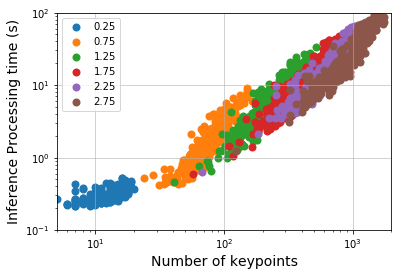

In [4]:
with open('testing_results/partial/raw_evaluation_properties.pickle','rb') as f:
    raw_evaluation_properties = pickle.load(f)
    
plt.grid(alpha = 0.7)
plt.ylim(0.1,100)
plt.xlim(5,2000)
plt.xlabel("Number of keypoints", fontsize = 14)
plt.ylabel("Inference Processing time (s)", fontsize = 14)
plt.xticks([10,100,1000],[10,100,1000])

overall_simp_properties = []

for radius, properties in raw_evaluation_properties:
    #properties = np.asarray(properties)
    simp_properties = []
    for ratio_s, index_s, score_s, proc_time in properties:
        simp_properties.append([
            radius, 
            ratio_s[0],
            proc_time
        ])
        
    
    simp_properties = np.asarray(simp_properties)
    plt.scatter(
        simp_properties[:,1],
        simp_properties[:,2],
        #facecolors = 'none',
        linewidth = 2,
        label = str(radius)
    )
    
    overall_simp_properties.append([
        radius,
        np.mean(simp_properties[:,1]),
        np.std(simp_properties[:,1]),
        np.mean(simp_properties[:,2]),
        np.std(simp_properties[:,2])
    ])

plt.xscale('log')
plt.yscale('log')
plt.legend()
    
#radius, properties[1]
overall_simp_properties =np.asarray(overall_simp_properties)

In [ ]:
descriptors = descriptors

keypoint_cap = 100

partial_results_path = os.path.join(results_path,"partial_exp")

if not os.path.exists(partial_results_path): os.mkdir(partial_results_path)
    
exp_raw_eval_propeties = []

for radius in np.arange(0.25,3.1,0.5):
    
    t0 = time.time()
    t1 = time.time()
        
    partial_scores_pool = []
    per_radius_properties = []
    
    print("radius =",radius)
    
    for s_i in sample_points_300:
        
        t3 = time.time()
        
        obj_, object_name, original_vertex = sample_points[s_i]
        
        pointCloud = []
        
        try:
            object_, pointCloud_, tri_ = new_contiguous_point_collection[int(obj_)]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get partial samples for",obj_meta[0])
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        try:
            obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                [obj_, object_name, original_vertex], 
                pointCloud, 
                descriptors,
                keypoint_cap,
                strict_cap = True
            )
            
        except Exception as ex:
            print(ex)
            print("skipped",object_name)
            continue
        
        if len(local_keypoint_matches) == 0: 
            print(0,"skipped",object_name)
            continue
            
        t4 = time.time()

        partial_scores_pool.append([
            [obj_, object_name, original_vertex], 
            diff_ratios,
            diff_indexs,
            diff_scores,
            local_keypoint_matches
        ])
                
        per_radius_properties.append([
            diff_ratios.shape,
            diff_indexs.shape,
            diff_scores.shape,
            t4 - t3
        ])

        if len(partial_scores_pool) % 66 == 2:
            
            partial_errors_pool = NN_matcher(partial_scores_pool)
            print("  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                len(partial_scores_pool),
                time.time()-t1,
                np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
            ))
            print("  ",
                  diff_ratios.shape,
                  diff_indexs.shape,
                  diff_scores.shape,
                  "in {:.3f} seconds".format(t4 - t3)
                 )
                 
            with bz2.BZ2File('testing_results/partial_exp/raw_{}_partial_scores_cap_{}.pickle.bz2'.format(radius, keypoint_cap), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)
            
            t1  = time.time()
            
    exp_raw_eval_propeties.append([
        radius,
        per_radius_properties
    ])
    
    with open('testing_results/partial_exp/raw_eval_properties_{}.pickle'.format(keypoint_cap), 'wb') as f:
        pickle.dump(exp_raw_eval_propeties, f)

    print(radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))
    
    #print(len(partial_lengths))
       

# Step 1.2: RANSAC-generalized spaces validation

In [7]:
descriptors = descriptors

keypoint_cap = 100

partial_results_path = os.path.join(results_path,"partial_exp")

if not os.path.exists(partial_results_path): os.mkdir(partial_results_path)
    
exp_eval_propeties = []

for radius in np.arange(1.25,3.1,0.5):
    
    t0 = time.time()
    t1 = time.time()
    
    partial_scores_pool = []
    per_radius_properties = []
    
    print("radius =",radius)
    
    for s_i in sample_points_300:
        
        t3 = time.time()
        
        obj_, object_name, original_vertex = sample_points[s_i]
        
        pointCloud = []
        
        try:
            trial = np.random.randint(5)
            
            with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
                ransac_trial_point_collection = pickle.load(f)

            object_, pointCloud_, tri_ = ransac_trial_point_collection[int(obj_)]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get ransac samples for",trial,obj_meta[0],dist_.shape,ind_.shape)
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        try:
            obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                [obj_, object_name, original_vertex], 
                pointCloud, 
                descriptors,
                key_cap=keypoint_cap,
                strict_cap=True
            )
            
        except Exception as ex:
            print(ex)
            print("skipped",object_name)
            continue
        
        if len(local_keypoint_matches) == 0: 
            print("skipped",object_name)
            continue

        t4 = time.time()

        partial_scores_pool.append([
            [obj_, object_name, original_vertex], 
            diff_ratios,
            diff_indexs,
            diff_scores,
            local_keypoint_matches
        ])
                
        per_radius_properties.append([
            diff_ratios.shape,
            diff_indexs.shape,
            diff_scores.shape,
            t4 - t3
        ])

        if len(partial_scores_pool) % 66 == 2:
            
            partial_errors_pool = NN_matcher(partial_scores_pool)
            print("  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                len(partial_scores_pool),
                time.time()-t1,
                np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
            ))
            print("  ",
                  diff_ratios.shape,
                  diff_indexs.shape,
                  diff_scores.shape,
                  "in {:.3f} seconds".format(t4 - t3)
                 )
                        
            with bz2.BZ2File('testing_results/partial_exp/ransac_{}_partial_scores_cap_{}.pickle.bz2'.format(radius, keypoint_cap), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)
                
            t1  = time.time()
            
    exp_eval_propeties.append([
        radius,
        per_radius_properties
    ])
    
    with open('testing_results/partial_exp/ransac_eval_properties_{}.pickle'.format(keypoint_cap), 'wb') as f:
        pickle.dump(exp_eval_propeties, f)

    print(radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))
    

    #print(len(partial_lengths))
       

radius = 1.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 2, in 4.017 seconds. Error rate 0.500
   (100, 7) (100, 7, 2) (100, 7, 2) in 2.760 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 68, in 409.002 seconds. Error rate 0.618
   (100, 7) (100, 7, 2) (100, 7, 2) in 5.801 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 134, in 378.619 seconds. Error rate 0.612
   (100, 7) (100, 7, 2) (100, 7, 2) in 2.161 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 200, in 330.606 seconds. Error rate 0.635
   (100, 7) (100, 7, 2) (100, 7, 2) in 7.172 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 266, in 346.869 seconds. Error rate 0.628
   (100, 7) (100, 7, 2) (100, 7, 2) in 2.470 seconds
1.25  Total Time to match 1611.411 seconds.
radius = 1.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 2, in 13.056 seconds. Error rate 0.500
   (100, 7) (100, 7, 2) (100, 7, 2) in 9.381 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 68, in 752.585 seconds. Error rate 0.603
   (100, 7) (100, 7, 2) (100, 7, 2) in 8.762 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 134, in 726.312 seconds. Error rate 0.582
   (100, 7) (100, 7, 2) (100, 7, 2) in 3.305 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 200, in 717.337 seconds. Error rate 0.550
   (100, 7) (100, 7, 2) (100, 7, 2) in 10.682 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 266, in 709.352 seconds. Error rate 0.549
   (100, 7) (100, 7, 2) (100, 7, 2) in 6.094 seconds
1.75  Total Time to match 3191.538 seconds.
radius = 2.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 2, in 26.231 seconds. Error rate 0.000
   (100, 7) (100, 7, 2) (100, 7, 2) in 18.652 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 68, in 1174.840 seconds. Error rate 0.441
   (100, 7) (100, 7, 2) (100, 7, 2) in 12.820 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 134, in 1239.254 seconds. Error rate 0.418
   (100, 7) (100, 7, 2) (100, 7, 2) in 5.743 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 200, in 1258.419 seconds. Error rate 0.395
   (100, 7) (100, 7, 2) (100, 7, 2) in 20.545 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 266, in 1202.143 seconds. Error rate 0.406
   (100, 7) (100, 7, 2) (100, 7, 2) in 9.065 seconds
2.25  Total Time to match 5400.502 seconds.
radius = 2.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.75 : Done with 2, in 42.231 seconds. Error rate 0.000
   (100, 7) (100, 7, 2) (100, 7, 2) in 29.020 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.75 : Done with 68, in 1854.659 seconds. Error rate 0.441
   (100, 7) (100, 7, 2) (100, 7, 2) in 15.640 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:648: RuntimeWarning: invalid value encountered in true_divide
  similarity_of_angle = np.sum(np.multiply(unq_diff_qry_kps,unq_diff_ref_kps), axis = -1)/np.multiply(Norm_unq_diff_qry_kps,Norm_unq_diff_ref_kps)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:658: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:665: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   2.75 : Done with 134, in 1872.096 seconds. Error rate 0.478
   (100, 7) (100, 7, 2) (100, 7, 2) in 9.049 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:648: RuntimeWarning: invalid value encountered in true_divide
  similarity_of_angle = np.sum(np.multiply(unq_diff_qry_kps,unq_diff_ref_kps), axis = -1)/np.multiply(Norm_unq_diff_qry_kps,Norm_unq_diff_ref_kps)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:658: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:665: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   2.75 : Done with 200, in 1921.080 seconds. Error rate 0.475
   (100, 7) (100, 7, 2) (100, 7, 2) in 29.955 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:648: RuntimeWarning: invalid value encountered in true_divide
  similarity_of_angle = np.sum(np.multiply(unq_diff_qry_kps,unq_diff_ref_kps), axis = -1)/np.multiply(Norm_unq_diff_qry_kps,Norm_unq_diff_ref_kps)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:658: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:665: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   2.75 : Done with 266, in 1710.505 seconds. Error rate 0.432
   (100, 7) (100, 7, 2) (100, 7, 2) in 10.554 seconds
2.75  Total Time to match 8095.553 seconds.


In [ ]:
descriptors = descriptors

for keypoint_cap in [30,50,70]:

#keypoint_cap = 100

    partial_results_path = os.path.join(results_path,"partial_capped_"+str(keypoint_cap))

    if not os.path.exists(partial_results_path): os.mkdir(partial_results_path)

    exp_eval_propeties = []

    for radius in np.arange(0.25,3.1,0.5):

        t0 = time.time()
        t1 = time.time()

        partial_scores_pool = []
        per_radius_properties = []

        print("radius =",radius)

        for s_i in sample_points_300:

            t3 = time.time()

            obj_, object_name, original_vertex = sample_points[s_i]

            pointCloud = []

            try:
                trial = np.random.randint(5)

                with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
                    ransac_trial_point_collection = pickle.load(f)

                object_, pointCloud_, tri_ = ransac_trial_point_collection[int(obj_)]

                ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])

                dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
                pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
            except:
                print("Can't get ransac samples for",trial,obj_meta[0],dist_.shape,ind_.shape)
                continue

            t4 = time.time()

            #if len(gen_planes) == 0: continue
            if len(pointCloud) == 0: continue

            local_keypoint_matches = []

            try:
                obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                    [obj_, object_name, original_vertex], 
                    pointCloud, 
                    descriptors,
                    key_cap=keypoint_cap,
                    strict_cap=True
                )

            except Exception as ex:
                print(ex)
                print("skipped",object_name)
                continue

            if len(local_keypoint_matches) == 0: 
                print("skipped",object_name)
                continue

            t5 = time.time()

            partial_scores_pool.append([
                [obj_, object_name, original_vertex], 
                diff_ratios,
                diff_indexs,
                diff_scores,
                local_keypoint_matches
            ])

            per_radius_properties.append([
                diff_ratios.shape,
                diff_indexs.shape,
                diff_scores.shape,
                [t5 - t4, t4 -t3] # inference time, extraction time
            ])

            if len(partial_scores_pool) % 66 == 2:

                partial_errors_pool = NN_matcher(partial_scores_pool)
                print(keypoint_cap,"  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                    len(partial_scores_pool),
                    time.time()-t1,
                    np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
                ))
                print("  ",
                      diff_ratios.shape,
                      diff_indexs.shape,
                      diff_scores.shape,
                      "extrated in {:.3f} seconds, inferred in {:.3f} seconds".format(t4 - t3, t5 - t4)
                     )

                t1  = time.time()
                
            with bz2.BZ2File('testing_results/partial_capped_{}/ransac_{}_partial_scores_cap.pickle.bz2'.format(keypoint_cap, radius), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)

        exp_eval_propeties.append([
            radius,
            per_radius_properties
        ])

        with open('testing_results/partial_capped_{}/ransac_eval_properties.pickle'.format(keypoint_cap), 'wb') as f:
            pickle.dump(exp_eval_propeties,f)

        print(keypoint_cap,radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))


radius = 0.25
30    0.25 : Done with 2, in 0.569 seconds. Error rate 1.000
   (11, 7) (11, 7, 2) (11, 7, 2) extrated in 0.036 seconds, inferred in 0.222 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.25 : Done with 68, in 21.763 seconds. Error rate 0.926
   (18, 7) (18, 7, 2) (18, 7, 2) extrated in 0.035 seconds, inferred in 0.384 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.25 : Done with 134, in 26.178 seconds. Error rate 0.910
   (13, 7) (13, 7, 2) (13, 7, 2) extrated in 0.040 seconds, inferred in 0.271 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.25 : Done with 200, in 32.469 seconds. Error rate 0.900
   (18, 7) (18, 7, 2) (18, 7, 2) extrated in 0.039 seconds, inferred in 0.304 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.25 : Done with 266, in 35.957 seconds. Error rate 0.883
   (9, 7) (9, 7, 2) (9, 7, 2) extrated in 0.050 seconds, inferred in 0.241 seconds
30 0.25  Total Time to match 137.291 seconds.
radius = 0.75
30    0.75 : Done with 2, in 1.144 seconds. Error rate 1.000
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.037 seconds, inferred in 0.587 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.75 : Done with 68, in 117.597 seconds. Error rate 0.838
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.039 seconds, inferred in 2.307 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.75 : Done with 134, in 115.996 seconds. Error rate 0.858
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.034 seconds, inferred in 0.534 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.75 : Done with 200, in 128.594 seconds. Error rate 0.830
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.036 seconds, inferred in 2.144 seconds


# Step 1.3: Results

In [22]:
results_partials_caps = []


for keypoint_cap in [30,50,70]:

    ransac_errors = []

    for radius in np.arange(0.25, 3.1, 0.5):

        try:
            with bz2.BZ2File('testing_results/partial_capped_{}/ransac_{}_partial_scores_cap.pickle.bz2'.format(keypoint_cap, radius), 'r') as bz2_f:
                partial_scores_pool = pickle.load(bz2_f) 

        except:
            print("Error getting Raw scores for",radius)
            continue

        partial_errors_pool = NN_matcher(partial_scores_pool)
        correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
        intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

        print(keypoint_cap,radius,"(Ransac) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
        print("   (Ransac) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 

        ransac_errors.append([
            radius,
            np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
            np.nanmean(intraspace_errors),
            np.nanstd(intraspace_errors)
        ])
        
    with open('testing_results/partial_capped_{}/ransac_eval_properties.pickle'.format(keypoint_cap), 'rb') as f:
        exp_eval_propeties = pickle.load(f)
        
    overall_simp_properties = []

    for radius, properties in exp_eval_propeties:
        
        properties = np.asarray(properties)

        simp_properties = []

        for ratio_s, index_s, score_s, [proc_time, extrct_time] in properties:
            simp_properties.append([
                radius, 
                ratio_s[0],
                proc_time,
                extrct_time
            ])

        simp_properties = np.asarray(simp_properties)
        
        overall_simp_properties.append([
            radius,
            np.mean(simp_properties[:,1]),
            np.std(simp_properties[:,1]),
            np.mean(simp_properties[:,2]),
            np.std(simp_properties[:,2]),
            np.mean(simp_properties[:,3]),
            np.std(simp_properties[:,3])
        ])
                
    results_partials_caps.append([
        keypoint_cap,
        np.asarray(ransac_errors),
        np.asarray(overall_simp_properties)
    ])
    
with open('testing_results/partial_exp/results_partials_caps.pickle', 'wb') as f:
    pickle.dump(results_partials_caps,f)
    

30 0.25 (Ransac) P1 Error Rate: 0.868421052631579
   (Ransac) P2 Error Rate: 6.211 (± 3.706)
30 0.75 (Ransac) P1 Error Rate: 0.8270676691729323
   (Ransac) P2 Error Rate: 5.604 (± 3.458)
30 1.25 (Ransac) P1 Error Rate: 0.6804511278195489
   (Ransac) P2 Error Rate: 3.332 (± 3.071)
30 1.75 (Ransac) P1 Error Rate: 0.6729323308270677
   (Ransac) P2 Error Rate: 3.200 (± 2.610)
30 2.25 (Ransac) P1 Error Rate: 0.6578947368421053
   (Ransac) P2 Error Rate: 3.206 (± 2.604)
30 2.75 (Ransac) P1 Error Rate: 0.6278195488721805
   (Ransac) P2 Error Rate: 3.069 (± 2.401)
50 0.25 (Ransac) P1 Error Rate: 0.8721804511278195
   (Ransac) P2 Error Rate: 6.589 (± 3.350)
50 0.75 (Ransac) P1 Error Rate: 0.8270676691729323
   (Ransac) P2 Error Rate: 4.527 (± 3.210)
50 1.25 (Ransac) P1 Error Rate: 0.6992481203007519
   (Ransac) P2 Error Rate: 3.644 (± 3.384)
50 1.75 (Ransac) P1 Error Rate: 0.5601503759398496
   (Ransac) P2 Error Rate: 3.200 (± 3.030)
50 2.25 (Ransac) P1 Error Rate: 0.5413533834586466
   (Ransac

Text(0.5, 1.0, 'NN-matcher')

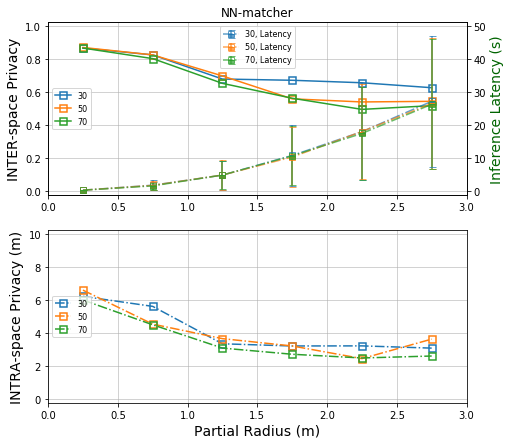

In [25]:
fig=plt.figure(figsize=(7.5, 7))

markersize = 7
linewidth = 1.5

ax2 = fig.add_subplot(212)#, sharex = ax1) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,3)
ax2.set_ylabel("INTRA-space Privacy (m)", fontsize = 14);
ax2.set_xlabel("Partial Radius (m)", fontsize = 14);

ax1 = fig.add_subplot(211, sharex = ax2) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("INTER-space Privacy", fontsize = 14);
#ax1.set_xlabel("Partial Radius", fontsize = 14);

ax3 = ax1.twinx()
ax3.set_ylim(-1.25,51.25);
#ax1.set_xlim(0,2.0)
ax3.set_ylabel("Inference Latency (s)", fontsize = 14, color = 'darkgreen');

with open('testing_results/partial_exp/results_partials_caps.pickle', 'rb') as f:
    results_partials_caps = pickle.load(f)
    
for cap, ransac_errors, properties in results_partials_caps:

    ax2.plot(
        ransac_errors[:,0],
        ransac_errors[:,2],
        '-.s',
        linewidth = linewidth,
        fillstyle = 'none',
        mew = linewidth,markersize = markersize,
        label = str(cap)
    )

    ax1.plot(
        ransac_errors[:,0],
        ransac_errors[:,1],
        "-s",
        linewidth = linewidth,
        fillstyle = 'none',
        mew = linewidth,markersize = markersize,
        label = str(cap)
    )

    ax3.errorbar(
        properties[:,0],
        properties[:,3],
        properties[:,4],
        marker = 's',
        alpha = 0.7,
        markersize = markersize-1,
        linestyle = '-.',
        fillstyle = 'bottom',
        #color = 'tab:green',
        capsize = markersize/2,
        label = str(cap)+", Latency"
    );

ax2.legend(loc = "center left", ncol = 1,fontsize = 8);#, bbox_to_anchor=(1.1, 1.5));
ax1.legend(loc = "center left", ncol = 1, fontsize = 8);# bbox_to_anchor=(1.1, 1.5));
#handles, labels = ax1.get_legend_handles_labels()

handles.append(p3), labels.append("Latency, Generalized")
#ax1.legend(handles, labels,loc = 'upper center', fontsize = 10)
ax3.legend(loc = 'upper center', ncol = 1, fontsize = 8)
#ax1.set_xlabel("Partial Radius")

plt.title("NN-matcher")

#plt.savefig('plots/one-time-partials-spaces.png', format='png', dpi=300,bbox_inches = 'tight')


Text(0.5, 1.0, 'NN-matcher')

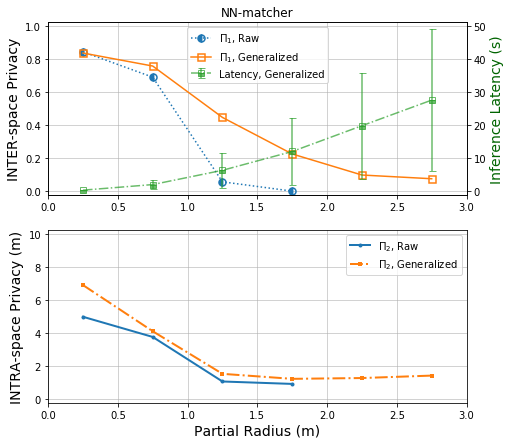

In [13]:
fig=plt.figure(figsize=(7.5, 7))

with open('testing_results/partial/results_partials_nn_matcher.pickle', 'rb') as f:
    results_partials = pickle.load(f)

RawNN = np.asarray(results_partials[0])
RansacNN = np.asarray(results_partials[1])
linewidth = 2.0
markersize = 2.0

ax2 = fig.add_subplot(212)#, sharex = ax1) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,3)

ax2.set_ylabel("INTRA-space Privacy (m)", fontsize = 14);
ax2.set_xlabel("Partial Radius (m)", fontsize = 14);
#ax2.set_yticklabels(fontsize = 16)
#ax2.set_xticklabels(fontsize = 16)

#plt.minorticks_on()

ax2.plot(
    RawNN[:,0],
    RawNN[:,2], 
    linewidth = linewidth, 
    marker = 'o',fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_2$, Raw"
)
ax2.plot(
    RansacNN[:,0],
    RansacNN[:,2],
    '-.s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_2$, Generalized"
)

ax2.legend(loc = "upper right", ncol = 1, fontsize = 10);#, bbox_to_anchor=(1.1, 1.5));

ax1 = fig.add_subplot(211, sharex = ax2) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("INTER-space Privacy", fontsize = 14);
#ax1.set_xlabel("Partial Radius", fontsize = 14);

markersize = 7
linewidth = 1.5

p1 = ax1.plot(
    RawNN[:,0],RawNN[:,1],
    ":o",
    linewidth = linewidth,fillstyle = 'left',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_1$, Raw"
)
p2 = ax1.plot(
    RansacNN[:,0],
    RansacNN[:,1],
    "-s",
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_1$, Generalized"
)

ax1.legend(loc = "upper right", ncol = 1, fontsize = 10);# bbox_to_anchor=(1.1, 1.5));
handles, labels = ax1.get_legend_handles_labels()

ax3 = ax1.twinx()
ax3.set_ylim(-1.25,51.25);
#ax1.set_xlim(0,2.0)
ax3.set_ylabel("Inference Latency (s)", fontsize = 14, color = 'darkgreen');

p3 = ax3.errorbar(
    overall_simp_properties[:,0],
    overall_simp_properties[:,3],
    overall_simp_properties[:,4],
    marker = 's',
    alpha = 0.7,
    markersize = markersize-1,
    linestyle = '-.',
    fillstyle = 'bottom',
    color = 'tab:green',
    capsize = markersize/2,
    label = "Latency"
);

handles.append(p3), labels.append("Latency, Generalized")
ax1.legend(handles, labels,loc = 'upper center', fontsize = 10)
#ax1.set_xlabel("Partial Radius")

plt.title("NN-matcher")

#plt.savefig('plots/one-time-partials-spaces.png', format='png', dpi=300,bbox_inches = 'tight')


# Functions

In [17]:

def getQuantizedPointCloudOnlyTEST(_point_cloud,scale = 5, verbose = False):
    
    np_pointCloud = np.asarray(np.copy(_point_cloud))
    
    round_new_pointcloud_only = (1.0/scale)*np.around(scale*_point_cloud[:,:3],decimals=0)
    unq_round_new_pointcloud, indices = np.unique(round_new_pointcloud_only,axis = 0, return_index = True)
    
    #print()
    n_pointCloud = np.hstack((unq_round_new_pointcloud, np_pointCloud[indices,3:]))
        
    return n_pointCloud


In [16]:
# Getting the "spin image" descriptors for a given point cloud    
def getSpinImageDescriptorsTEST(_point_cloud,
                            resolution = 20,
                            normalize = True,
                            down_resolution = 3, #keypoint resolution
                            #localize = False,
                            local_radius = 1.0,
                            cylindrical_quantization = [10,20],
                            verbose = False,
                            old = False,
                            key_cap = 50, 
                            strict_cap = False
                           ):
    
    np_pointCloud = np.asarray(np.copy(_point_cloud))
    other_pc = np.copy(np_pointCloud)
    
    t0 = time.time()
    
    if old:
        chosen_points = getQuantizedPointCloudOnly(np_pointCloud,down_resolution,verbose=verbose)
        if verbose: print("Old:",chosen_points.shape)
    else:
        chosen_points = getQuantizedPointCloudOnlyTEST(np_pointCloud,down_resolution,verbose=verbose)
        if verbose: print("New:",chosen_points.shape)

    chosen_points = np.delete(chosen_points,np.where(LA.norm(chosen_points[:,3:],axis=1)== 0)[0],0)
    
    t1 = time.time()
    
    if strict_cap and len(chosen_points) > key_cap:
        chosen_points = chosen_points[np.random.choice(len(chosen_points),key_cap)]
        if verbose: print("Capped chosen points to", key_cap)
    
    """
    if verbose:
        unique_normals = np.unique(chosen_points[:,3:],axis=0)

        for normal in unique_normals:

            if np.round(np.abs(np.dot(normal,[0,1,0]))) == 0:
                print("  IN Complete",object_name,"Vertical",np.abs(np.dot(normal,[0,1,0])),normal,LA.norm(normal,2))
                print("  IN Chosen Points before:",chosen_points.shape)
                #vertical = True

    """
    
    view_invariant_descriptor_cylinders = np.zeros(
        (np.append(len(chosen_points),
                   np.asarray(cylindrical_quantization)
                   #np.asarray(cylindrical_quantization*0.5*resolution,dtype = np.uint32)
                   #[int(resolution*cylindrical_quantization[0]),int(resolution*cylindrical_quantization[1])]
                  )
        ), dtype=np.float16)
    #    shape is (number of points, number of a bins, number of b bins)
    #print(view_invariant_descriptor_cylinders.shape)

    for i,c_p in enumerate(chosen_points):

        k_ps = other_pc[:,:3] - c_p[:3] # point (vertex) differences
        k_ps = np.delete(k_ps,np.where(LA.norm(k_ps,axis=1)==0)[0],0) # removing itself

        #if localize:
        #    k_ps = np.delete(k_ps,np.where(LA.norm(k_ps,axis=1)>local_radius)[0],0)

        theta = np.arccos(np.clip(np.sum(c_p[3:]*k_ps,axis=1)/(LA.norm(c_p[3:])*LA.norm(k_ps,axis=1)),-1,1))# normal at keypoint

        d_a = cylindrical_quantization[0]*LA.norm(k_ps,axis=1)*np.sin(theta)
        d_b = np.clip(cylindrical_quantization[1]*0.5*LA.norm(k_ps,axis=1)*np.cos(theta)+cylindrical_quantization[1]*0.5,
                      0,cylindrical_quantization[1]-1)
        
        # removing the points that are outside of the spin region
        k_ps = np.delete(k_ps,np.where(d_a>=cylindrical_quantization[0]-1)[0],0)
        d_b = np.delete(d_b,np.where(d_a>=cylindrical_quantization[0]-1)[0],0)
        d_a = np.delete(d_a,np.where(d_a>=cylindrical_quantization[0]-1)[0],0)

        k_ps = np.delete(k_ps,np.where(d_b>=cylindrical_quantization[1]-1)[0],0)
        d_a = np.delete(d_a,np.where(d_b>=cylindrical_quantization[1]-1)[0],0)
        d_b = np.delete(d_b,np.where(d_b>=cylindrical_quantization[1]-1)[0],0)
        
        a = np.ceil(np.clip(d_a,0,cylindrical_quantization[0]-1))
        b = np.ceil(np.clip(d_b,0,cylindrical_quantization[1]-1))

        for k,_ in enumerate(k_ps):
            
            if LA.norm(k_ps[k]) == 0:
                continue

            # skip points that are beyond the scope of the pre-defined descriptor
            if d_a[k] >= cylindrical_quantization[0]-1 or d_b[k] >= cylindrical_quantization[1]-1:
                continue
            if d_a[k]>a[k] or d_b[k]>b[k]:
                continue
            diff_a = a[k]-d_a[k]
            diff_b = b[k]-d_b[k]
            
            if diff_a > 1 or diff_b > 1:# or diff_a == 0 or diff_b == 0:
                continue
                
            view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])] += (diff_a)*(diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])] += (1-diff_a)*(diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])-1] += (diff_a)*(1-diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])-1] += (1-diff_a)*(1-diff_b)

    view_invariant_descriptors = []

    for descriptors in view_invariant_descriptor_cylinders:
        if normalize: # max-normalization
            if np.amax(descriptors) == 0:
                pass
            else:
                descriptors = descriptors/np.amax(descriptors)
        view_invariant_descriptors.append(descriptors.flatten('C'))

    t2 = time.time()
    #print("Time to get spin image descriptors",time.time()-t0)
        #print(view_invariant_descriptors.shape)
    """    
    if verbose:
        unique_normals = np.unique(chosen_points[:,3:],axis=0)
        print("  IN Chosen Points after:",chosen_points.shape)

        for normal in unique_normals:

            if np.round(np.abs(np.dot(normal,[0,1,0]))) == 0:
                print("  IN Chosen",object_name,"Vertical",np.abs(np.dot(normal,[0,1,0])),normal,LA.norm(normal,2))
    """    
    view_invariant_descriptors = np.asarray(view_invariant_descriptors)
    
    return view_invariant_descriptors, chosen_points, view_invariant_descriptor_cylinders, t1-t0, t2- t1


In [22]:
# Getting the "spin image" descriptors for a given point cloud    
def getSpinImageDescriptorsTryTest(_point_cloud,
                            resolution = 20,
                            normalize = True,
                            down_resolution = 3, #keypoint resolution
                            #localize = False,
                            local_radius = 1.0,
                            cylindrical_quantization = [10,20],
                            verbose = False,
                            old = False,
                            key_cap = 50, 
                            strict_cap = False
                           ):
    
    np_pointCloud = np.asarray(np.copy(_point_cloud))
    other_pc = np.copy(np_pointCloud)
    
    t0 = time.time()
    
    if old:
        chosen_points = OLDgetQuantizedPointCloudOnly(np_pointCloud,down_resolution,verbose=verbose)
        if verbose: print("Old:",chosen_points.shape)
    else:
        chosen_points = getQuantizedPointCloudOnlyTEST(np_pointCloud,down_resolution,verbose=verbose)
        if verbose: print("New:",chosen_points.shape)

    chosen_points = np.delete(chosen_points,np.where(LA.norm(chosen_points[:,3:],axis=1)== 0)[0],0)
    
    t1 = time.time()
    
    if strict_cap and len(chosen_points) > key_cap:
        chosen_points = chosen_points[np.random.choice(len(chosen_points),key_cap)]
        if verbose: print("Capped chosen points to", key_cap)
    
    """
    if verbose:
        unique_normals = np.unique(chosen_points[:,3:],axis=0)

        for normal in unique_normals:

            if np.round(np.abs(np.dot(normal,[0,1,0]))) == 0:
                print("  IN Complete",object_name,"Vertical",np.abs(np.dot(normal,[0,1,0])),normal,LA.norm(normal,2))
                print("  IN Chosen Points before:",chosen_points.shape)
                #vertical = True

    """
    
    view_invariant_descriptor_cylinders = np.zeros(
        (np.append(len(chosen_points),
                   np.asarray(cylindrical_quantization)
                   #np.asarray(cylindrical_quantization*0.5*resolution,dtype = np.uint32)
                   #[int(resolution*cylindrical_quantization[0]),int(resolution*cylindrical_quantization[1])]
                  )
        ), dtype=np.float16)
    #    shape is (number of points, number of a bins, number of b bins)
    #print(view_invariant_descriptor_cylinders.shape)
    
    #for i,c_p in enumerate(chosen_points):

    k_ps = other_pc[:,np.newaxis,:3] - chosen_points[np.newaxis,:,:3] # point (vertex) differences
    #k_ps = np.delete(k_ps,np.where(LA.norm(k_ps,axis=-1)==0)[0],0) # removing itself
    #print("Chosen points:",chosen_points.shape, "Other PC: ", other_pc.shape, "KP shape:",k_ps.shape)

    theta = np.arccos(np.clip(np.sum(chosen_points[np.newaxis,:,:3]*k_ps,axis=-1)/(LA.norm(chosen_points[np.newaxis,:,:3])*LA.norm(k_ps,axis=-1)),-1,1))# normal at keypoint
    d_a = cylindrical_quantization[0]*LA.norm(k_ps,axis=-1)*np.sin(theta)
    d_b = np.clip(cylindrical_quantization[1]*0.5*LA.norm(k_ps,axis=-1)*np.cos(theta)+cylindrical_quantization[1]*0.5,
                  0,cylindrical_quantization[1]-1)
    
    #print("Theta:",theta.shape, "D_a", d_a.shape, "D_b", d_b.shape)
    
    i_a = np.ceil(d_a)
    i_b = np.ceil(d_b)

    diff_a = i_a - d_a
    diff_b = i_b - d_b
    
    mult = diff_a*diff_b
    
    #print("KP shape:",k_ps.shape, "new _a", diff_a.shape, "new _b", diff_b.shape, "mult shape", mult.shape)
    
    """
            view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])] += (diff_a)*(diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])] += (1-diff_a)*(diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])-1] += (diff_a)*(1-diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])-1] += (1-diff_a)*(1-diff_b)
    """

    for k, k_p in enumerate(k_ps):

        submap = np.zeros((len(chosen_points),
            max(cylindrical_quantization[0]+3,int(max(d_a[k]))),
            max(cylindrical_quantization[1]+3,int(max(d_b[k])))
        ))

        a_i = np.clip(np.searchsorted(np.arange(max(cylindrical_quantization[0]+2,int(max(i_a[k])))),i_a[k],side="right")-1,0,cylindrical_quantization[0]+2)
        b_i = np.clip(np.searchsorted(np.arange(max(cylindrical_quantization[1]+2,int(max(i_b[k])))),i_b[k],side="right")-1,0,cylindrical_quantization[1]+2)
        a_i_s = np.clip(np.searchsorted(np.arange(max(cylindrical_quantization[0]+2,int(max(i_a[k])))),i_a[k]-1,side="right")-1,0,cylindrical_quantization[0]+2)
        b_i_s = np.clip(np.searchsorted(np.arange(max(cylindrical_quantization[1]+2,int(max(i_b[k])))),i_b[k]-1,side="right")-1,0,cylindrical_quantization[1]+2)

        submap[np.arange(len(chosen_points)),a_i,b_i] += diff_a[k]*diff_b[k]    
        submap[np.arange(len(chosen_points)),a_i_s,b_i] += (1-diff_a[k])*diff_b[k]
        submap[np.arange(len(chosen_points)),a_i,b_i_s] += diff_a[k]*(1-diff_b[k])
        submap[np.arange(len(chosen_points)),a_i_s,b_i_s] += (1-diff_a[k])*(1-diff_b[k])

        view_invariant_descriptor_cylinders += submap[:,:cylindrical_quantization[0],:cylindrical_quantization[1]]

    view_invariant_descriptors = []

    for descriptors in view_invariant_descriptor_cylinders:
        if normalize: # max-normalization
            if np.amax(descriptors) == 0:
                pass
            else:
                descriptors = descriptors/np.amax(descriptors)
        view_invariant_descriptors.append(descriptors.flatten('C'))

    t2 = time.time()
    #print("Time to get spin image descriptors",time.time()-t0)
        #print(view_invariant_descriptors.shape)
    """    
    if verbose:
        unique_normals = np.unique(chosen_points[:,3:],axis=0)
        print("  IN Chosen Points after:",chosen_points.shape)

        for normal in unique_normals:

            if np.round(np.abs(np.dot(normal,[0,1,0]))) == 0:
                print("  IN Chosen",object_name,"Vertical",np.abs(np.dot(normal,[0,1,0])),normal,LA.norm(normal,2))
    """    
    view_invariant_descriptors = np.asarray(view_invariant_descriptors)
    
    if verbose: 
        print("\n  desc shape:",view_invariant_descriptor_cylinders.shape, " kp's shape",chosen_points.shape)
        print("  To get keypoints {:.3f} seconds, to get descriptors {:.3f} seconds".format(t1-t0,t2-t1))
    
    return view_invariant_descriptors, chosen_points, view_invariant_descriptor_cylinders, t1-t0, t2- t1

